# Decoding Cellphone Signals with a Quantum Computer

This notebook demonstrates the use of a quantum computer for decoding transmissions 
in cellular networks and compares performance to state-of-the-art classical 
decoding. It has the following sections:

1. [Modeling a Network](#Modeling-a-Network) models a wireless/cellular network with nearest-neighbor
    connectivity.
2. [Decoding Transmissions: Classical Resources](#Decoding-Transmissions:-Classical-Resources) 
    presents three decoders used in today's cellular networks. 
3. [Decoding Transmissions: Quantum Resources](#Decoding-Transmissions:-Quantum-Resources) 
    demonstrates the use of a quantum computer to decode transmissions.
4. [Supplementary Technical Material](#Supplementary-Technical-Material) provides 
    additional, more-detailed technical information.

## A Hard (and Expensive) Problem

The number of [base stations](https://en.wikipedia.org/wiki/Cell_site) required to 
serve a large city depends on the stations' signal-processing capacities. Unfortunately, 
small increases to environmental noise and cellphone numbers quickly harden[[1]](#1) 
the problem of decoding transmissions. The graphic below shows the dependency of 
transmission errors on 
[SNRb](https://en.wikipedia.org/wiki/Signal-to-noise_ratio), the signal-to-noise ratio per bit, and 
on $\frac{Tx}{Rx}$, the ratio of transmitters (e.g. cellphones) to receivers (e.g., base stations)
in the wireless network of this example. 

<img src="_static/problem_hardness_3d.png" width="500">

The world's ubiquitous cellphones require huge numbers of base stations; for example, 
in mid 2022, China's Ministry of Industry and Information Technology reported having 
deployed almost 
[2 million base stations](https://techblog.comsoc.org/2022/08/19/china-miit-claim-475m-5g-mobile-users-1-97m-5g-base-stations-at-end-of-july-2022/) 
for its 5G network alone.

A paper, [[2]](#2), presented in [SIGCOMM](https://www.sigcomm.org/) 2019 states, "For optimal 
performance, an amount of computation that increases at an exponential rate both with the 
number of users and with the data rate of each user is often required. The base station’s 
computational capacity is thus becoming one of the key limiting factors on wireless capacity." 

However, power consumption scales steeply with computation capacity (with the notable 
exception of quantum computers: an Advantage&#8482; requires just 25kW for its operation) and 
powering base stations has become 
[enormously challenging](https://techblog.comsoc.org/2020/08/07/5g-base-station-deployments-open-ran-competition-huge-5g-bs-power-problem/).  

Profitability for network providers is now driven by seemingly conflicting imperatives: 
(1) reducing power consumption and (2) increasing processing capability.

## What is Coordinated Multipoint?

Shortly after the first generation of cellular networks were deployed it became clear that 
the naive model of pairing cellphones to a single nearby base station is inadequate. Many 
technologies have been developed to boost performance. 
[Cooperative MIMO](https://en.wikipedia.org/wiki/Cooperative_MIMO) (multiple-input multiple-output) 
effectively exploits the spatial domain of mobile fading channels to significantly improve 
performance. In one of its variations, coordinated multipoint (CoMP), neighboring base stations 
share data and channel state information to enable them to coordinate downlink transmissions 
and jointly process received signals. This aggregated processing reduces the bit error rate 
(BER) compared to decoding the cellphone's transmission over a single channel but requires 
more powerful computation. 

[Cloud radio access network (C-RAN)](https://en.wikipedia.org/wiki/C-RAN), one form
of CoMP, shifts processing from base stations to a shared data center. This notebook 
explores the advantages of incorporating a quantum computer into such data centers for 
improving performance with reduced power consumption.

## References

<a name="1">[1]</a> Toshiyuki Tanaka. 
A Statistical-Mechanics Approach to Large-System Analysis of CDMA Multiuser Detectors.
IEEE TRANSACTIONS ON INFORMATION THEORY, VOL. 48, NO. 11, NOVEMBER 2002

<a name="2">[2]</a> Minsung Kim, Davide Venturelli, and Kyle Jamieson. 
Leveraging quantum annealing for large MIMO processing in centralized radio access networks.
SIGCOMM '19: Proceedings of the ACM Special Interest Group on Data Communication, August 2019, Pages 241–255 
https://dl.acm.org/doi/10.1145/3341302.3342072

# Modeling a Network

A cellular network can be modelled as a lattice: some nodes represent cellphones (transmitters, 
denoted $T_x$), others base stations (receivers, $R_x$); edges between $T_x$ and $R_x$ nodes 
represent transmission channels. $T_x$ nodes can have edges to multiple $R_x$ nodes because, in 
CoMP, base stations can forward received signals, which have propagated through different channels 
with various noise, to be jointly processed.

The graphic below illustrates the network used in this example:

* Circles: red are transmitters (cellphones) and green are receivers (base stations).
* Lines: red form the lattice of transmitters and green connect transmitters to receivers. 
* Black dotted square: four receivers, shown outlined with black circles, receive transmissions
    from transmitter Tx, in the center, as well as transmissions from another eight transmitters, 
    outlined in blue. (The four blue-outlined transmitters horizontally and vertically aligned with 
    the center transmitter are its *nearest neighbors*; the other four, on the diagonals, are 
    the *next-nearest neighbors*.) Based on the signal received by the four outlined receivers, 
    the problem is to distinguish the center transmitter's signal from signals received from 
    its nearest and next-nearest neighbors.   

<img src="_static/network.png" width="500">

Increasing the number of $T_x$ nodes relative to $R_x$ nodes (the $\frac{Tx}{Rx}$ ratio), raises 
the processing load, simulating base stations in densely populated areas with many cellphones 
communicating simultaneously. 

This first code cell imports the functionality needed for the following sections. 

In [1]:
# General Python packages
import matplotlib.pyplot as plt
import numpy as np

# Ocean software packages
import dimod
from dwave.system import DWaveSampler, FixedEmbeddingComposite

# Functions of this repository
from helpers.draw import draw_loop_comparison, draw_network
from helpers.filters import apply_filters, compare_signals, create_filters, time_filter_instantiation
from helpers.general import loop_comparisons
from helpers.network import configure_network, create_channels, print_network_stats, simulate_signals

from dwave.samplers import SimulatedAnnealingSampler

# Enable graphics inline
%matplotlib inline 

# Remove once dimod's mimo functions are updated
import warnings
warnings.filterwarnings('ignore')

## Create a Network Graph

The `configure_network` function in the code cell below returns a network based on a lattice 
that connects each node to its nearest neighbors. $T_x$ and $R_x$ nodes alternate, representing
a network in which most<sup>[1]</sup> cellphones can transmit to four base stations. By default, 
it returns a network based on a $45x45$ lattice with a ratio of $\frac{Tx}{Rx} \approx 1.5$, 
achieved by randomly "turning off" some number of base stations. 

For visual clarity, this first section sets `network_size=5` for a network based on a 12x12 
lattice (lattice length is $3n-3=12$ for $n=5$).

<sup>[1]<sub>With the exception of nodes on the lattice boundaries and receivers turned off to achieve the desired transmitters-to-receivers ratio.</sub></sup>

The `draw_network` function colors transmitters in red and receivers in green. 

Ratio of transmitters to receivers: 1.47.
Network has 129 transmitters and 88 receivers with 516 edges.


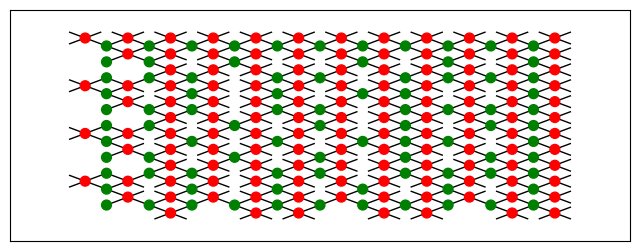

In [2]:
network, _ = configure_network(network_size=5)

print_network_stats(network)
draw_network(network)

## Create Channels

The `create_channels` function below simulates the channels between transmitters and receivers. By 
default, it generates channels with a binary, real distribution that represents 
[inter-symbol interference (ISI)](https://en.wikipedia.org/wiki/Intersymbol_interference): each 
element of transmission sequences base station receive can be constituted of the emitted symbols 
of more than one cellphone.

In [3]:
channels, channel_power = create_channels(network)
print(f"Channels are represented by a {channels.shape[0]}x{channels.shape[1]} matrix.")

Channels are represented by a 88x129 matrix.


# Decoding Transmissions: Classical Resources

To distinguish between the transmitted signals from multiple cellphones, and symbols from 
[additive environmental noise](https://en.wikipedia.org/wiki/Additive_white_Gaussian_noise), 
base stations standardly process (decode) transmissions with one of the following linear filters:

* [Matched filter](https://en.wikipedia.org/wiki/Matched_filter) is the optimal linear filter 
    for maximizing signal-to-noise ratio (SNR) of channels modelled as having additive stochastic 
    noise. It uses the technique of [convolution](https://en.wikipedia.org/wiki/Convolution) with a 
    conjugated time-reversed signal template.
* [Zero forcing](https://en.wikipedia.org/wiki/Zero-forcing_precoding) applies the inverse of the 
    channel frequency response to the received signal to restore the pre-transmission signal.
* [Minimum mean squared error (MMSE)](https://en.wikipedia.org/wiki/Minimum_mean_square_error) 
    minimizes the mean square error (MSE) between the transmitted and the received signal to 
    mitigate effects of ISI and noise. 

## Create Filters

The `create_filters` function below instantiates all three linear filters described above.

<div class="alert alert-warning" role="alert" style="margin: 10px">Note: Linear filters 
are instantiated for the channels they are intended to decode and such are short-lived. 
This crucial time constraint is considered in the following sections.</div>

In [4]:
filters = create_filters(channels)
print(f"Created filters: {list(filters.keys())}.")

Created filters: ['zero_forcing', 'matched_filter', 'MMSE'].


## Simulate Transmissions

Cellular and wireless networks standardly use amplitude and phase modulation to encode 
transmissions. 

<img src="_static/qam.png" width="600">

Typically used encodings include:

* BPSK: Binary Phase Shift Keying. Transmission symbols are the real values $+1, -1$. This 
    is the encoding demonstrated in this example.
* QPSK: Quadrature Phase Shift Keying. Transmission symbols are the complex values
    $1+j, 1-j, -1+j, -1-j$. 
* 16-QAM: 16 complex-valued QPSK symbols modulated by either 1 or 3.
* 64-QAM and 256-QAM: these scale up 16-QAM.

The `simulate_signals` function below simulates the original and received transmissions:

* `transmitted_symbols` is a sequence of BPSK symbols selected from a uniform random distribution.
* `y` is the signal received by the base stations, the result of the instantiated channels acting 
    upon the transmitted symbols. 

In [5]:
y, transmitted_symbols = simulate_signals(channels, channel_power)                 
print(f"First 10 transmitted symbols: {transmitted_symbols.flatten()[:10]}. \nFirst 10 received symbols: {y.flatten()[:10]}.")

First 10 transmitted symbols: [-1 -1 -1 -1  1 -1 -1  1  1 -1]. 
First 10 received symbols: [ 1.  2.  1. -2. -3.  0. -3.  1. -1.  1.].


## Decode Received Signals

Use the `apply_filters` function below to decode, with each of the three linear filters, the signal 
received by the network's base stations. The `compare_signals` function then performs a bit-by-bit 
comparison between the received signal and the symbols transmitted by the network's cellphones.

In [6]:
v = apply_filters(y, filters)
_ = compare_signals(v, transmitted_symbols)

zero_forcing: decoded with a success rate of 92%.
matched_filter: decoded with a success rate of 73%.
MMSE: decoded with a success rate of 92%.


The preceding operations of this section do **not** account for two significant factors 
of real-world networks:

1. Cellular networks impose strict constraints on processing time.
2. In addition to the ISI represented by the simulated channel above, wireless environments are noisy. 
   The `simulate_signals` function can represent real wireless channels by adding random normal noise 
   to the transmitted symbols.

The following sections take these factors into consideration.

# Scaling Up

In cellular networks, processing time is crucial: base stations/C-RANs must 
decode any received transmission frames (a defined number of sequential transmitted symbols) 
and return acknowledgements within a prescribed amount of time. For Wi-Fi networks, 
this imposes a hard requirement on processing time of tens of microseconds. In newer cellphone 
networks such as 4G LTE, receivers must process transmissions with similar speed due to 
redundancy schemes. 

Consequently, networks adopt processing algorithms such as linear filters that meet the speed 
requirements, even if performance is suboptimal.

As noted above, linear filters are adapted specifically for the instantiated channels; in network
terms, the filter's parameters are calibrated to the currently existing channels as periodically 
measured by having the network transmit a known pilot signal. The lifetime of such channels is 
tens of milliseconds. As a result, networks use filters that can be instantiated/calibrated fast. 

The `time_filter_instantiation` function below measures instantiation times for each of the three
linear filters for a few different sizes of networks. Any instantiation times greater than half a 
second (500 milliseconds) are highlighted in red in the output. 

A more detailed comparison is given in the [Technical Supplement](#Technical-Supplement) section below.


For a network of 129 cellphones and 87 base stations:

	* zero_forcing took about 6 milliseconds.
	* matched_filter took about 0 milliseconds.
	* MMSE took about 4 milliseconds.

For a network of 694 cellphones and 476 base stations:

	* zero_forcing took about 108 milliseconds.
	* matched_filter took about 1 milliseconds.
	* MMSE took about 89 milliseconds.

For a network of 1709 cellphones and 1160 base stations:

	* zero_forcing took about  707  milliseconds.
	* matched_filter took about 5 milliseconds.
	* MMSE took about  553  milliseconds.


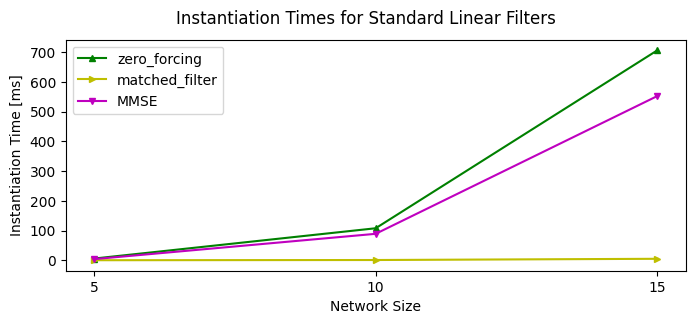

In [7]:
time_filter_instantiation(network_sizes=[5, 10, 15])

The matched-filter algorithm scales up well and can be used in large wireless networks.
The other two filters require a time-consuming mathematical operation, matrix inversion. 
Matrix inversion is slow even on GPUs and does not parallelize well. 

In the following sections, which demonstrate operations on networks of size 16, only the 
matched-filter algorithm is used.

# Decoding Transmissions: Quantum Resources

This section demonstrates using a quantum computer to decode wireless transmissions. 

First, select a quantum computer using [Ocean](https://docs.ocean.dwavesys.com/en/stable/index.html) 
software's [DWaveSampler](https://docs.ocean.dwavesys.com/en/stable/docs_system/reference/samplers.html)
class.

By default, the quantum processing unit (QPU) with the greatest number of available qubits is selected.
As of August 2023, that quantum computer is always an Advantage, which is based on the 
[Pegasus topology](https://docs.dwavesys.com/docs/latest/c_gs_4.html). Although unnecessary, the 
preferred topology is explicitly set as a parameter to highlight that this example is designed for 
compliance with the Pegasus architecture. For further information, see the 
[Technical Supplement](#Technical-Supplement) section below.


In [8]:
# qpu = DWaveSampler(solver=dict(topology__type="pegasus"))

qpu = SimulatedAnnealingSampler()

print(f"Selected SAMPLERNAME sampler")

# print(f"Selected {qpu.solver.name} with {len(qpu.nodelist)} qubits.")

Selected SAMPLERNAME sampler


## BQM Representation (Small-Town Problem)

Any problem to be solved on a quantum computer 
[must be expressed](https://docs.dwavesys.com/docs/latest/c_gs_workflow.html) as a 
binary quadratic model (BQM). 

This subsection demonstrates the following operations: 

* Create a network model that can be represented on the selected QPU.
* Simulate a **noisy** transmission and decode it using the matched-filter algorithm.
* Create a BQM representing the decoding problem and solve it on the quantum computer.

### Create the Problem and Decode Classically

First, repeat the operations of the previous section but now using parameters `qpu` and `SNRb`:

* `SNRb` sets the level of noise the `simulate_signals` function adds to the received signal, `y`.
* `qpu` gives the `configure_network` function access to the selected QPU's
    [working graph](https://docs.dwavesys.com/docs/latest/c_gs_4.html#the-working-graph). The function
    uses it to generate the returned `embedding` variable, which is needed in the 
    [Decode Received Signals](#Decode-Received-Signals) subsection below. 

For comparison, also decode the transmission with a matched filter. 

In [9]:
SNRb = 10

# Create a model network
network, embedding = configure_network(network_size=16, qpu=None)
print_network_stats(network)

# Model the channel used for a particular transmission interval
channels, channel_power =  create_channels(network)

# Instantiate a matched filter for the transmission interval
filter_mf = create_filters(channels, methods=['matched_filter'])
y, transmitted_symbols = simulate_signals(channels, channel_power, SNRb=SNRb)  

# Decode the transmission with the linear filter and compare to the original transmitted symbols
v = apply_filters(y, filter_mf) 
_ = compare_signals(v, transmitted_symbols)

Ratio of transmitters to receivers: 1.46.
Network has 1951 transmitters and 1337 receivers with 7804 edges.
matched_filter: decoded with a success rate of 79%.


### Create a BQM

Ocean's [dimod](https://docs.ocean.dwavesys.com/en/stable/docs_dimod/sdk_index.html) package
provides [generators](https://docs.ocean.dwavesys.com/en/stable/docs_dimod/reference/generators.html) 
for various common problems. Below, use the `spin_encoded_comp` generator to translate the network 
problem into a BQM.

For this example's case of BPSK, where symbols are 1 or -1, the reduced objective function,

![eq3](_static/eq_e_quadratic.png)

where $H$ is the Hamiltonian and $N_r, N_t$ are the numbers of receivers and transmitters,
is represented by the Ising model,

![eq4](_static/eq_h_j.png)

where superscript Q and I denote imaginary and real parts, respectively. 

In [10]:
bqm = dimod.generators.wireless.coordinated_multipoint(network, 
                                                       modulation='BPSK',
                                                       F_distribution=('binary','real'), 
                                                       F=channels,
                                                       y=y)

print(f"BQM has {len(bqm)} variables with {len(bqm.quadratic)} quadratic interactions.")

BQM has 1951 variables with 5372 quadratic interactions.


### Decode Received Signals

Use the selected quantum computer to decode the transmission.

Ocean software's 
[FixedEmbeddingComposite](https://docs.ocean.dwavesys.com/en/stable/docs_system/reference/composites.html#fixedembeddingcomposite)
handles the mapping between the problem's variables ($T_x$ nodes of the network) and the QPU's
qubits, using the `embedding` variable found above as the 
[minor-embedding](https://docs.dwavesys.com/docs/latest/c_gs_7.html). 

More information about the minor-embedding, and the QPU parameters used below, is given in the 
[Technical Supplement](#Technical-Supplement) section. 

In [11]:
# sampler = FixedEmbeddingComposite(qpu, embedding)

sampler = SimulatedAnnealingSampler()

sampleset = sampler.sample(bqm, 
                           num_reads=30, 
                           annealing_time=200, 
                           chain_strength=-0.13*min(bqm.linear.values()),
                           label='Notebook - Coordinated Multipoint')

_ = compare_signals(sampleset, transmitted_symbols)

Decoded with a success rate of 94%.


## Big-City Problems

Problems become harder[[1]](#1) with increases to channel noise and base-station load. 
The graphic below shows the bit error rate (BER) as a function of SNRb and $\frac{Tx}{Rx}$ 
for a large network (`network_size=16`). Each data point is the median of ten problems 
solved by running simulated annealing for hundreds of times longer than the practicable 
runtimes used in this notebook (around 10 seconds versus 30 milliseconds used to 
meet wireless-network requirements).

<img src="_static/problem_hardness.png" width="800">

One sees, for example, that for SNRb of 5 and $\frac{Tx}{Rx}=1.5$, the expected BER approaches 
10%. Toward the top left of this graphic, interference and noise are sufficient to introduce 
high levels of bit errors in even ideal decoders that obtain the ground state (equivalent 
to the maximum likelihood solution). 

The next cell runs `runs` number of problems. By default, its `loop_comparisons` function 
sets `network_size=16`, SNRb to 5 and the $\frac{Tx}{Rx}$ ratio to 1.5.  

Ratio of transmitters to receivers: 1.49.
Network has 1951 transmitters and 1310 receivers with 7804 edges.
Run number: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

	 * Median success rate for QPU: nan.
	 * Median success rate for matched_filter: 81.0.


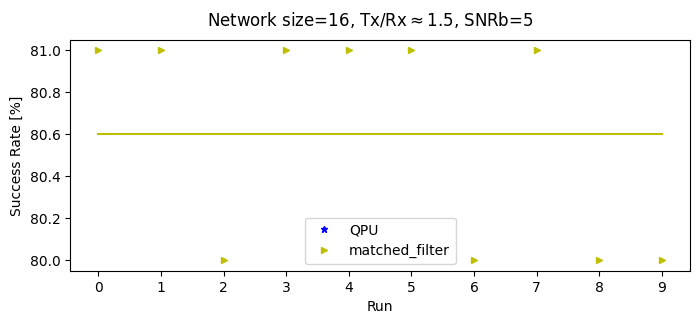

In [12]:
results = loop_comparisons(runs=10, qpu=None)
medians = {filter: np.median(val) for filter, val in results.items()}

for solver in medians:
    print(f'\t * Median success rate for {solver}: {medians[solver]}.')

draw_loop_comparison(results)

### Rough-Neighborhood Problems

For completeness, this subsection demonstrates a particularly hard problem by setting high 
values of noise and load. You can configure `SNR` and `tx_to_rx` below to your own preferred 
values.

Ratio of transmitters to receivers: 1.61.
Network has 1951 transmitters and 1209 receivers with 7804 edges.
Run number: 0, 1, 2, 3, 4, 

	 * Median success rate for QPU: nan.
	 * Median success rate for matched_filter: 79.0.


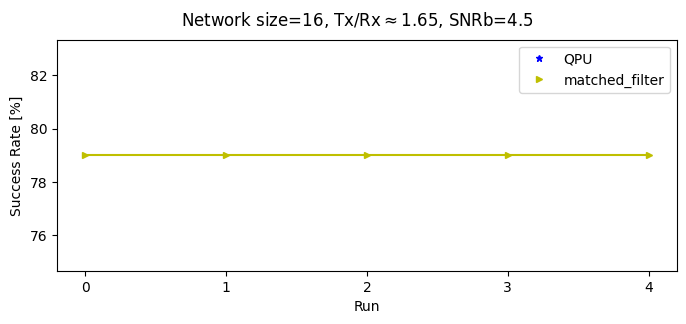

In [13]:
SNRb = 4.5
tx_to_rx = 1.65


results = loop_comparisons(runs=5, qpu=None, snr=SNRb, ratio=tx_to_rx)
medians = {filter: np.median(val) for filter, val in results.items()}

for solver in medians:
    print(f'\t * Median success rate for {solver}: {medians[solver]}.')

draw_loop_comparison(results, SNRb=SNRb, ratio=tx_to_rx)

# Technical Supplement

This section provides more technical details on some of the topics demonstrated above.

## Performance of Matrix-Inverting Filters 

Processing time in Wi-Fi/cellular networks is crucial: base stations or C-RANs must 
decode transmissions in at most tens of milliseconds. 

As demonstrated above, the matched-filter algorithm scales up well and can be used in large wireless networks.
The other two filters require a time-consuming mathematical operation, matrix inversion, which is slow even on 
GPUs and does not parallelize well. 

For a range of network sizes, the next plot shows the following information:

* Decoding success rate (left). Each data point is the mean of ten problems with SNRb of 5 and $\frac{Tx}{Rx}=1.5$. 
* Instantiation time (right). Times were measured on a 10-core i5 Intel processor operating at 1600 Mhz.  

<img src="_static/all_matched_filters_performance.png" width="800">

Instantiation times that exceed a second, as they do for the matrix-inverting filters, preclude their usage
in processing transmissions for networks above certain scales. 

## Comparison to Simulated Annealing

[Simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing) is a powerful heuristic
that dominates the space of general solvers. For many problems it is considered the benchmark 
for performance.

Like the matrix inversion required to instantiate the zero-forcing and MMSE linear filters, 
simulated annealing is computationally demanding: it requires a strong processor with high 
power consumption. 

For the comparisons of this subsection, assume that an algorithm running on a CPU requires 
10e-8 seconds per variable update: a network of size 16 has about 2000 variables ($T_x$ nodes),
so each sweep of simulated annealing takes around 200 microseconds. To compare performance to the QPU with 
its [access time](https://docs.dwavesys.com/docs/latest/c_qpu_timing.html#qpu-access-time) of about 
30 milliseconds, the `loop_comparisons` function runs simulated annealing for 150 sweeps. By default, 
it runs on a network of size 16 with SNRb  of 5 and  $\frac{Tx}{Rx}=1.5$.

Ratio of transmitters to receivers: 1.5.
Network has 1951 transmitters and 1304 receivers with 7804 edges.
Run number: 0, 1, 2, 3, 4, 

	 * Median success rate for QPU: nan.
	 * Median success rate for SA: 86.0.


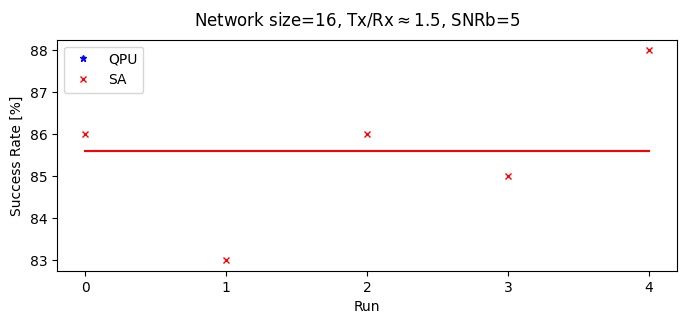

In [14]:
results = loop_comparisons(runs=5, qpu=None, solvers=['SA'])
medians = {filter: np.median(val) for filter, val in results.items()}

for solver in medians:
    print(f'\t * Median success rate for {solver}: {medians[solver]}.')

draw_loop_comparison(results)

## Comparison to Other Classical Algorithms

For completeness, this subsection demonstrates comparisons to additional algorithms standardly used
to solve hard problems:

* [Steepest Descent](https://docs.ocean.dwavesys.com/en/stable/docs_samplers/index.html#steepest-descent), 
    a discrete analogue of the [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) technique.
* [Tabu](https://docs.ocean.dwavesys.com/en/stable/docs_samplers/index.html#tabu), a heuristic that employs 
    local search with methods to escape local minima.

Like simulated annealing, both are computationally demanding.  

Ratio of transmitters to receivers: 1.45.
Network has 1951 transmitters and 1343 receivers with 7804 edges.
Run number: 0, 1, 2, 3, 4, 

	 * Median success rate for QPU: nan.
	 * Median success rate for greedy: 77.0.
	 * Median success rate for tabu: 80.0.


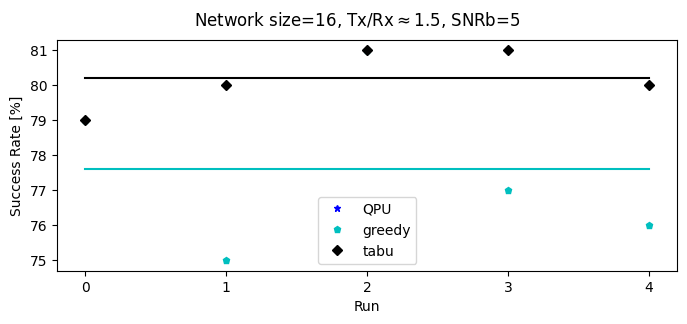

In [15]:
results = loop_comparisons(runs=5, qpu=None, solvers=['greedy', 'tabu'])
medians = {filter: np.median(val) for filter, val in results.items()}

for solver in medians:
    print(f'\t * Median success rate for {solver}: {medians[solver]}.')

draw_loop_comparison(results)

### Preprocessing Performance

For completeness, this subsection also looks at the performance of 
[preprocessing](https://en.wikipedia.org/wiki/Data_Preprocessing). For some classes of problems,
a short period of preprocessing prior to running a solver can result in improved solutions and 
runtimes. 

The plot below shows the use of 
[roof duality](https://docs.ocean.dwavesys.com/en/stable/docs_preprocessing/reference/composites.html#fix-variables-composite)
to fix variables before applying a tabu sampler. Each point on the plot represents the median of 
20 problems. 

<img src="_static/preprocessing.png" width="700">

One sees that as problems harden&mdash;size and $\frac{T_x}{R_x}$ increase and SNRb decreases&mdash;preprocessing 
loses effectiveness.

### Postprocessing Performance

For completeness, this subsection also looks at the performance of postprocessing. For some classes of problems,
a short period of postprocessing the results of running a solver can result in improved solutions at the cost 
of somewhat longer runtimes. 

The plot below shows the use of 
[SteepestDescentSolver](https://docs.ocean.dwavesys.com/en/stable/docs_greedy/reference/samplers.html#steepestdescentsolver),
a greedy solver, to find a minimum near the returned result of a linear filter and the quantum computer. Each 
point on the plot represents the median of 10 problems. 

This combination of a matched filter with greedy post-processing can be considered a form of iterative decoding 
(also called [message passing](https://en.wikipedia.org/wiki/Message_passing), or 
[loopy belief propagation](https://en.wikipedia.org/wiki/Belief_propagation)). Iterative decoding is used 
in some SOTA base stations and can be implemented in the cooperative multi-point problem so as to scale 
only linearly with the number of base stations (as in this example), and, like the QPU and unlike linear 
filters, can account for non-linearities.

<img src="_static/postprocessing.png" width="700">

One sees that as problems harden&mdash;size and $\frac{T_x}{R_x}$ increase and SNRb decreases&mdash;postprocessing 
produces less improvement.

## Configuring Optimal QPU Parameters

Ocean software selects reasonable default parameters when submitting problems to the 
quantum computer. However, when performance in crucial, as in these problems, where 
differences of a percent matter, it is important to configure the QPU with optimal 
parameter values. D-Wave's [system documentation](https://docs.dwavesys.com/docs/latest/doc_handbook.html)
provides guidance on optimizing QPU use.

Here, two non-default parameters are used:

* [annealing_time](https://docs.dwavesys.com/docs/latest/c_solver_parameters.html#annealing-time) sets 
    the duration, in microseconds, of quantum annealing time, per read. 

    For time-critical problems, rather than use the default 20 microseconds with a large 
    number of reads, a good rule of thumb is to balance the programming and sampling times 
    in the overall [QPU access time](https://docs.dwavesys.com/docs/latest/c_qpu_timing.html#qpu-access-time).
    The QPU access time 
    [estimation](https://docs.dwavesys.com/docs/latest/c_qpu_timing.html#estimating-access-time) algorithm 
    and companion Ocean tool produce an optimal annealing time of just over 200 microseconds for 
    most the problems in this example.
     
* [Chain strength](https://docs.ocean.dwavesys.com/en/stable/docs_system/reference/generated/dwave.system.composites.FixedEmbeddingComposite.sample.html)
    sets the coupling strength between qubits that form a 
    [chain](https://docs.dwavesys.com/docs/latest/c_gs_7.html#chains). 

    For most problems, the default 
    [chain-strength calculation](https://docs.ocean.dwavesys.com/en/stable/docs_system/reference/generated/dwave.embedding.chain_strength.uniform_torque_compensation.html)
    produces decent results. For this problem, however, it does not.

    The following plot shows the bit error rate (BER) and the fraction of broken chains for a range
    of chain strengths, calculated as `-cs_multiplier*min(bqm.linear.values())`, where `cs_multiplier` 
    is a multiplier of the most negative value of $h_i$, the linear coefficients of the BQM. Each data 
    point is the median of twenty problems with SNRb of 5 and $\frac{Tx}{Rx}=1.5$ for a large network (`network_size=16`). 

    The optimal chain strength of around $-0.13\min{h_i}$ produces consistently good performance for all
    the problem instances (the range of network sizes, SNR, $\frac{Tx}{Rx}$ ratio, and transmission 
    patterns) of this example.

<img src="_static/chain_strength.png" width="700">

## Minor Embedding

For most problems submitted directly to the QPU, mapping between the problem's variables and 
QPU qubits is heuristic, automated by such tools as Ocean's 
[minorminer](https://docs.ocean.dwavesys.com/en/stable/docs_minorminer/source/sdk_index.html) 
package. 

Although that package also provides algorithms for minor-embedding graphs with regularities, 
one can produce more efficient embeddings by tiling an optimal cell embedding across the full
graph. However, because the 
QPU [working graph](https://docs.dwavesys.com/docs/latest/c_gs_4.html#the-working-graph) 
can contain defects due to some small number of qubits and couplers being removed for failing 
to meet the specifications to function as desired, one needs to shift the mapping around those. 
The `configure_network` function handles this.

The graphic below shows how a small network graph (`network_size=4`) is minor-embedded into the 
selected QPU's working graph. 

Colored dots are qubits: note that pairs of identically-colored dots (two-qubit chains), such as the blue, green, and red pairs on the top row, represent a single node of the logical network. 

<img src="_static/embedding_lattice4.png" width="700">


Copyright &copy; 2023 D-Wave Systems, Inc

The software is licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This Jupyter Notebook is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>